In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal


from astroNN.nn.layers import MCDropout
# import scipy as sp
# from scipy.interpolate import interp1d

2023-04-03 21:45:54.137384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 21:45:54.241206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 21:45:54.241224: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-03 21:45:54.947942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
file = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon%2B_lcparam_full_long_zhel.txt'
syscov_file = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon%2B_sys_full_long.txt'
# file = 'data/lcparam_full_long.txt'
df = pd.read_csv(file, sep = " ")
# df = pd.read_csv(file, sep = " ")
N = len(df.values)
syscov = np.loadtxt(syscov_file, skiprows=1).reshape((N, N))
cov = np.copy(syscov)

In [4]:
df.head()

,CID,zHD,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,MU_SH0ES,MU_SH0ES_ERR_DIAG,CEPH_DIST,IS_CALIBRATOR,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,0.00122,0.00082,0.00002,9.74571,1.516210,28.9987,1.516450,29.1770,1,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,0.00122,0.00082,0.00002,9.80286,1.517230,29.0559,1.517470,29.1770,1,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,0.00256,0.00144,0.00002,11.47030,0.781906,30.7233,0.782372,30.8433,1,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,0.00256,0.00144,0.00002,11.49190,0.798612,30.7449,0.799068,30.8433,1,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,0.00299,0.00187,0.00004,11.52270,0.880798,30.7757,0.881212,-9.0000,0,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


In [5]:
np.diag_indices_from(cov)

(array([   0,    1,    2, ..., 1698, 1699, 1700]),
 array([   0,    1,    2, ..., 1698, 1699, 1700]))

In [6]:
# ww = (df['zHD']>0.01)
# ii = -1
# f = open(syscov_file)
# line = f.readline()
# n = int(len(df))
# C = np.zeros((n,n))
# for i in range(len(df)):
#     jj = -1
#     if ww[i]:
#         ii += 1
#         for j in range(len(df)):
#             if ww[j]:
#                 jj += 1
#             val = float(f.readline())
#             if ww[i]:
#                 if ww[j]:
#                     C[ii,jj] = val
# cov = C

In [7]:
# np.diag(C)

In [8]:
sq_errors = np.diag(syscov)

In [9]:
# df['errors'] = np.sqrt(sq_errors+dmag**2)
df['errors'] = np.sqrt(sq_errors)
df.describe()

,zHD,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,MU_SH0ES,MU_SH0ES_ERR_DIAG,CEPH_DIST,IS_CALIBRATOR,USED_IN_SH0ES_HF,...,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD,errors
count,1701.000000,1701.00000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,...,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000,1701.000000
mean,0.221229,0.22143,0.001155,19.083629,0.240920,38.336629,0.242601,-7.135358,0.045267,0.162845,...,36.499118,47.227484,0.469040,0.104899,0.061886,-0.009629,0.004541,0.972350,0.008889,0.169411
std,0.249271,0.24944,0.002774,3.374499,0.098815,3.374499,0.098390,8.568397,0.207951,0.369333,...,23.891781,67.434767,0.378961,0.055224,0.096221,0.074649,0.005048,0.089824,0.009789,0.059434
min,0.001220,0.00082,0.000000,9.745710,0.111583,28.998700,0.114803,-9.000000,0.000000,0.000000,...,0.000000,0.219440,0.000000,0.034300,0.004300,-0.535600,0.000000,0.164000,0.000000,0.080278
25%,0.027730,0.02716,0.000020,16.036200,0.178788,35.289200,0.180815,-9.000000,0.000000,0.000000,...,20.000000,18.316200,0.062870,0.065700,0.010800,-0.050900,0.002000,1.000000,0.003000,0.128216
50%,0.163750,0.16470,0.000150,20.076300,0.217323,39.329300,0.218994,-9.000000,0.000000,0.000000,...,34.000000,33.036300,0.441920,0.087100,0.028800,0.001500,0.003000,1.000000,0.006000,0.155560
75%,0.328680,0.32961,0.001000,21.824800,0.278656,41.077800,0.279961,-9.000000,0.000000,0.000000,...,48.000000,51.953600,0.865830,0.124800,0.076900,0.034500,0.005000,1.000000,0.012000,0.195335
max,2.261370,2.26000,0.040000,26.929800,1.517230,46.182800,1.517470,34.526000,1.000000,1.000000,...,280.000000,1106.220000,1.000000,0.493300,1.496000,0.365300,0.050000,1.000000,0.063000,0.625326


In [34]:
# df['mb'] += 19.36
df = df[['zHD','m_b_corr','errors']]
df.head()

,zHD,m_b_corr,errors
0,0.00122,9.74571,0.178244
1,0.00122,9.80286,0.185921
2,0.00256,11.47030,0.247502
3,0.00256,11.49190,0.276550
4,0.00299,11.52270,0.625326


Text(0, 0.5, '$\\mu(z)$')

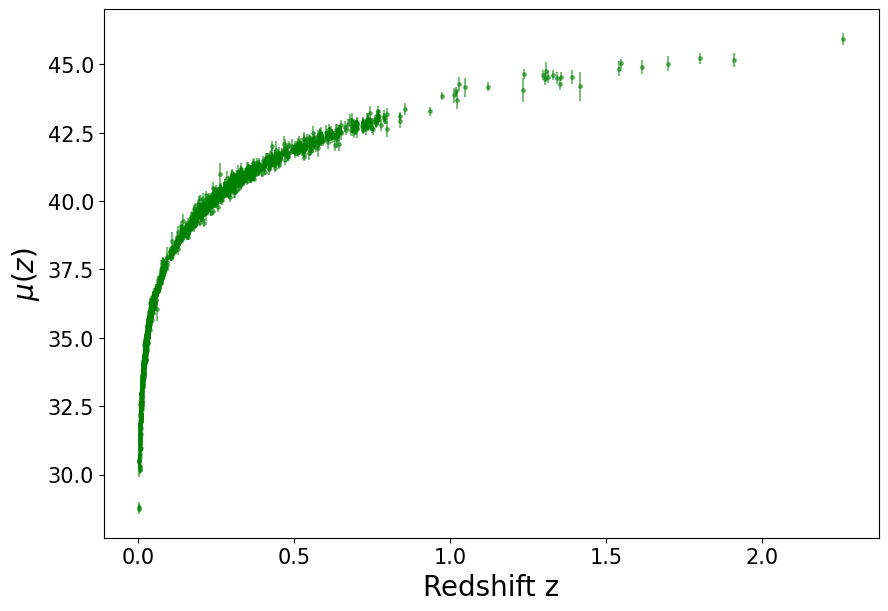

In [16]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zHD'], df['m_b_corr']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
# plt.xlim(0, 2.3)

In [17]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [18]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [19]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [20]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [21]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [22]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [23]:
def model2(input_z):
    x = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(x)
    x = Dense(150, activation='relu')(x)
    elast = Dense(2, activation='linear')(x)


    return elast


input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 dense_3 (Dense)             (None, 2)                 302       
                                                                 
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


2023-04-03 21:47:20.381348: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-03 21:47:20.381377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: isidro-PC
2023-04-03 21:47:20.381382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: isidro-PC
2023-04-03 21:47:20.381493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.89.2
2023-04-03 21:47:20.381513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.89.2
2023-04-03 21:47:20.381517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.89.2
2023-04-03 21:47:20.382255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAP

#### Ahora usando incertidumbres de la red con Monte Carlo Dropout

In [24]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((1360, 1), (1360, 1), (341, 1), (341, 1))

In [25]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 50])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/800
340/340 [==============================] - 1s 2ms/step - loss: 42.0409 - val_loss: 8.9422
Epoch 2/800
340/340 [==============================] - 0s 1ms/step - loss: 8.4844 - val_loss: 8.2348
Epoch 3/800
340/340 [==============================] - 0s 1ms/step - loss: 6.4969 - val_loss: 6.2785
Epoch 4/800
340/340 [==============================] - 0s 1ms/step - loss: 6.2133 - val_loss: 5.0516
Epoch 5/800
340/340 [==============================] - 0s 1ms/step - loss: 5.5477 - val_loss: 4.8025
Epoch 6/800
340/340 [==============================] - 0s 1ms/step - loss: 5.1467 - val_loss: 5.1171
Epoch 7/800
340/340 [==============================] - 0s 1ms/step - loss: 5.0686 - val_loss: 5.3481
Epoch 8/800
340/340 [==============================] - 0s 1ms/step - loss: 4.5869 - val_loss: 5.0078
Epoch 9/800
340/340 [==============================] - 0s 1ms/step - loss: 4.9658 - val_loss: 4.8061
Epoch 10/800
340/340 [==============================] - 0s 1ms/step - loss: 4.3757 - val_l

340/340 [==============================] - 0s 1ms/step - loss: 1.7963 - val_loss: 1.7880
Epoch 82/800
340/340 [==============================] - 0s 1ms/step - loss: 1.8800 - val_loss: 1.9404
Epoch 83/800
340/340 [==============================] - 0s 1ms/step - loss: 1.7679 - val_loss: 1.8717
Epoch 84/800
340/340 [==============================] - 0s 1ms/step - loss: 1.7778 - val_loss: 1.8701
Epoch 85/800
340/340 [==============================] - 0s 1ms/step - loss: 1.9587 - val_loss: 1.8046
Epoch 86/800
340/340 [==============================] - 0s 1ms/step - loss: 1.8558 - val_loss: 1.9482
Epoch 87/800
340/340 [==============================] - 0s 1ms/step - loss: 1.8765 - val_loss: 1.7150
Epoch 88/800
340/340 [==============================] - 0s 1ms/step - loss: 1.7341 - val_loss: 1.6203
Epoch 89/800
340/340 [==============================] - 0s 1ms/step - loss: 1.6341 - val_loss: 1.5923
Epoch 90/800
340/340 [==============================] - 0s 1ms/step - loss: 1.7152 - val_loss: 

Epoch 161/800
340/340 [==============================] - 0s 1ms/step - loss: 0.7021 - val_loss: 0.7544
Epoch 162/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6386 - val_loss: 0.6595
Epoch 163/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6563 - val_loss: 0.5432
Epoch 164/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6968 - val_loss: 0.6289
Epoch 165/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6606 - val_loss: 0.7076
Epoch 166/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6898 - val_loss: 0.6012
Epoch 167/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6287 - val_loss: 0.6029
Epoch 168/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6475 - val_loss: 0.5983
Epoch 169/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6149 - val_loss: 0.5877
Epoch 170/800
340/340 [==============================] - 0s 1ms/step - lo

340/340 [==============================] - 0s 1ms/step - loss: 0.3215 - val_loss: 0.3402
Epoch 241/800
340/340 [==============================] - 0s 1ms/step - loss: 0.3380 - val_loss: 0.2527
Epoch 242/800
340/340 [==============================] - 0s 1ms/step - loss: 0.3241 - val_loss: 0.3541
Epoch 243/800
340/340 [==============================] - 0s 1ms/step - loss: 0.3071 - val_loss: 0.3241
Epoch 244/800
340/340 [==============================] - 0s 1ms/step - loss: 0.3309 - val_loss: 0.2819
Epoch 245/800
340/340 [==============================] - 0s 1ms/step - loss: 0.3412 - val_loss: 0.2919
Epoch 246/800
340/340 [==============================] - 0s 1ms/step - loss: 0.3173 - val_loss: 0.3452
Epoch 247/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2995 - val_loss: 0.2612
Epoch 248/800
340/340 [==============================] - 0s 1ms/step - loss: 0.3076 - val_loss: 0.3246
Epoch 249/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2767 - v

Epoch 319/800
340/340 [==============================] - 0s 977us/step - loss: 0.2626 - val_loss: 0.2575
Epoch 320/800
340/340 [==============================] - 0s 991us/step - loss: 0.2614 - val_loss: 0.2324
Epoch 321/800
340/340 [==============================] - 0s 974us/step - loss: 0.2399 - val_loss: 0.2376
Epoch 322/800
340/340 [==============================] - 0s 984us/step - loss: 0.2623 - val_loss: 0.2153
Epoch 323/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2365 - val_loss: 0.2086
Epoch 324/800
340/340 [==============================] - 0s 971us/step - loss: 0.2503 - val_loss: 0.2730
Epoch 325/800
340/340 [==============================] - 0s 969us/step - loss: 0.2282 - val_loss: 0.1901
Epoch 326/800
340/340 [==============================] - 0s 986us/step - loss: 0.2331 - val_loss: 0.2355
Epoch 327/800
340/340 [==============================] - 0s 978us/step - loss: 0.2292 - val_loss: 0.2791
Epoch 328/800
340/340 [==============================] - 

340/340 [==============================] - 0s 1ms/step - loss: 0.2169 - val_loss: 0.2138
Epoch 398/800
340/340 [==============================] - 0s 999us/step - loss: 0.2198 - val_loss: 0.2283
Epoch 399/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2043 - val_loss: 0.2253
Epoch 400/800
340/340 [==============================] - 0s 991us/step - loss: 0.2277 - val_loss: 0.1944
Epoch 401/800
340/340 [==============================] - 0s 965us/step - loss: 0.2434 - val_loss: 0.2533
Epoch 402/800
340/340 [==============================] - 0s 985us/step - loss: 0.2333 - val_loss: 0.2250
Epoch 403/800
340/340 [==============================] - 0s 982us/step - loss: 0.2258 - val_loss: 0.1917
Epoch 404/800
340/340 [==============================] - 0s 983us/step - loss: 0.2132 - val_loss: 0.1963
Epoch 405/800
340/340 [==============================] - 0s 978us/step - loss: 0.2187 - val_loss: 0.1954
Epoch 406/800
340/340 [==============================] - 0s 1ms/step - lo

340/340 [==============================] - 0s 1ms/step - loss: 0.2140 - val_loss: 0.2228
Epoch 477/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2198 - val_loss: 0.1953
Epoch 478/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2049 - val_loss: 0.2118
Epoch 479/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2201 - val_loss: 0.2319
Epoch 480/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2177 - val_loss: 0.2581
Epoch 481/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2403 - val_loss: 0.2356
Epoch 482/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2083 - val_loss: 0.2383
Epoch 483/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2269 - val_loss: 0.2487
Epoch 484/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2184 - val_loss: 0.2441
Epoch 485/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2210 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.1977 - val_loss: 0.2263
Epoch 556/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1974 - val_loss: 0.2161
Epoch 557/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2101 - val_loss: 0.2042
Epoch 558/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2239 - val_loss: 0.2249
Epoch 559/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2285 - val_loss: 0.2070
Epoch 560/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1892 - val_loss: 0.2538
Epoch 561/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2138 - val_loss: 0.1908
Epoch 562/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2327 - val_loss: 0.2118
Epoch 563/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2293 - val_loss: 0.1945
Epoch 564/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2081 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.2242 - val_loss: 0.2172
Epoch 635/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2178 - val_loss: 0.1948
Epoch 636/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2205 - val_loss: 0.2465
Epoch 637/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2347 - val_loss: 0.1961
Epoch 638/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2133 - val_loss: 0.2266
Epoch 639/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2178 - val_loss: 0.2033
Epoch 640/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2378 - val_loss: 0.2325
Epoch 641/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2229 - val_loss: 0.2684
Epoch 642/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2173 - val_loss: 0.2373
Epoch 643/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2376 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.2335 - val_loss: 0.1769
Epoch 714/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2060 - val_loss: 0.2336
Epoch 715/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2279 - val_loss: 0.2265
Epoch 716/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2093 - val_loss: 0.2267
Epoch 717/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2167 - val_loss: 0.2635
Epoch 718/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2256 - val_loss: 0.2009
Epoch 719/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2162 - val_loss: 0.1589
Epoch 720/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2197 - val_loss: 0.1849
Epoch 721/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2057 - val_loss: 0.2200
Epoch 722/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2210 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.2114 - val_loss: 0.2080
Epoch 793/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2137 - val_loss: 0.1964
Epoch 794/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2174 - val_loss: 0.2018
Epoch 795/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2132 - val_loss: 0.2395
Epoch 796/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2091 - val_loss: 0.1916
Epoch 797/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2246 - val_loss: 0.2479
Epoch 798/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1962 - val_loss: 0.2506
Epoch 799/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2108 - val_loss: 0.1925
Epoch 800/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2289 - val_loss: 0.1974


In [26]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

32/32 [==============================] - 0s 871us/step


In [27]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.930420381026092, 0.02689167500795032)

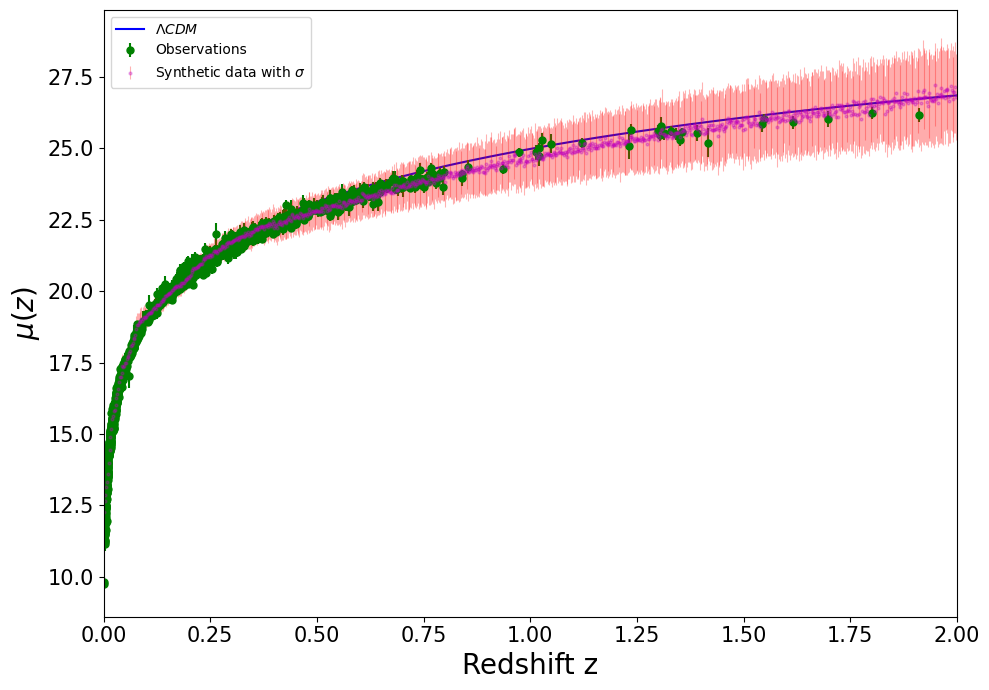

In [46]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zHD'], df['m_b_corr'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()
plt.savefig('plots/pantheon_plus_rec.png', dpi=100)

In [40]:
 prediction_mc_dropout[0,:]

array([12.2595662 ,  0.26538942])

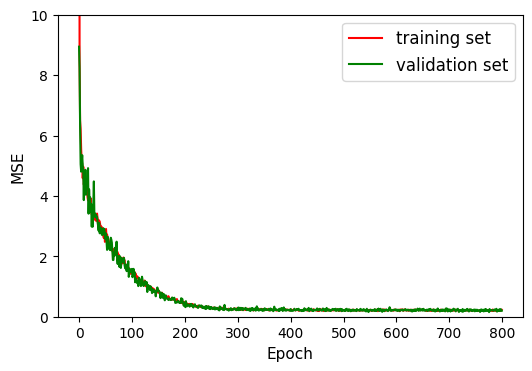

In [47]:
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0,10)
plt.savefig('plots/pantheon_plus_loss.png', dpi=100)

In [48]:
model.save('models/Pantheon_plus.h5')
# tf.keras.models.save_model(neural_model2, '../models/FFNN_MC_DO.h5' )